In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(func.count(measurement.date)).all()

[(19550)]

In [11]:
# Calculate the date 1 year ago from the last data point in the database
first_date = session.query(measurement.date).order_by(measurement.date).first()
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
latest_date_str = latest_date.strftime('%Y-%m-%d')

query_date = dt.datetime(latest_date.year -1, latest_date.month, latest_date.day)
query_date_str = query_date.strftime('%Y-%m-%d')

print(f"Date 1yr before: {query_date}\nLatest date    : {latest_date}")

Date 1yr before: 2016-08-23 00:00:00
Latest date    : 2017-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

qry = [measurement.date,measurement.prcp]
query_result = session.query(*qry).filter(measurement.date >= query_date).all()
precipitation = pd.DataFrame(query_result, columns=['day', 'precipitation'])
precipitation = precipitation.dropna(how='any')

# convert the days to a datetime
precipitation['day'] = pd.to_datetime(precipitation['day'])

# set the days as the df index and sort the dataframe on day
precipitation.set_index('day', inplace=True)
precipitation.sort_values('day', ascending=True)
precipitation.reset_index()

,day,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2010,2017-08-17,0.13
2011,2017-08-19,0.09
2012,2017-08-21,0.56
2013,2017-08-22,0.50


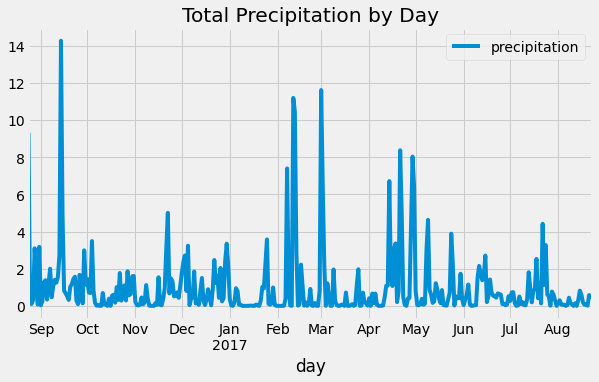

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

# group the data by day and plot
daily_precipitation = precipitation.groupby(['day']).sum()
line_graph = daily_precipitation.plot(kind='line',title='Total Precipitation by Day',figsize=(9,5))


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
daily_precipitation.describe()

,precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [measurement.station,func.count(measurement.id)]
activestations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

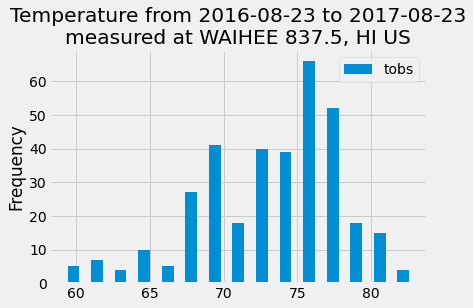

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(measurement.tobs).\
    filter(measurement.station == activestations[0]
[0]).\
    filter(measurement.date >= query_date).all()
temperatures = list(np.ravel(queryresult))

sel = [station.station, station.name, station.latitude, station.longitude, station.elevation]
queryresult = session.query(*sel).all()
stations_df = pd.DataFrame(queryresult, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

station_name = stations_df.loc[stations_df["Station"]
== activestations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=15, rwidth=.5, label='tobs')
plt.ylabel('Frequency')
plt.title(f"Temperature from {query_date_str} to {latest_date_str}\nmeasured at {station_name}")
plt.legend()
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-12-01'
end_date = '2016-12-16'
temps_result = calc_temps(start_date, end_date)[0]
temps_result

(60.0, 70.21904761904761, 78.0)

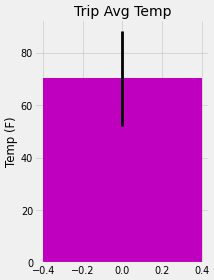

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [temps_result[1]]
error = [(temps_result[2] - temps_result[0])]
          

plt.figure(figsize=(4,6), dpi=50)
plt.bar(x_pos,y_pos, color='m', yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-01-01'
end_date = '2018-01-01'

sel = [station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]
queryresult = session.query(*sel).\
    filter(station.station == measurement.station).\
    group_by(measurement.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    order_by(func.sum(measurement.prcp).desc()).\
    all()

stations = pd.DataFrame(queryresult, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'PrcpSum'])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,68.78
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,43.66
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,34.62
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,27.32
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,21.80
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,10.66
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.39


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-12-01'
end_date = '2016-12-16'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dtobj = dt.datetime.strptime(start_date, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(end_date, '%Y-%m-%d')

tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

[[65.0, 71.91666666666667, 78.0],
 [62.0, 71.32692307692308, 77.0],
 [67.0, 72.88679245283019, 79.0],
 [66.0, 72.17647058823529, 81.0],
 [64.0, 70.92156862745098, 78.0],
 [61.0, 69.3921568627451, 78.0],
 [58.0, 69.2, 79.0],
 [60.0, 70.27450980392157, 83.0],
 [64.0, 71.90196078431373, 80.0],
 [61.0, 71.24528301886792, 78.0],
 [64.0, 72.38775510204081, 78.0],
 [64.0, 70.88235294117646, 79.0],
 [65.0, 70.9423076923077, 80.0],
 [65.0, 71.18, 78.0],
 [62.0, 71.34, 79.0],
 [60.0, 69.62264150943396, 82.0]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trips = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trips['Date'] = tripdates
trips = trips.set_index("Date")
trips

,tmin,tavg,tmax
Date,,,
2016-12-01,65.0,71.916667,78.0
2016-12-02,62.0,71.326923,77.0
2016-12-03,67.0,72.886792,79.0
2016-12-04,66.0,72.176471,81.0
2016-12-05,64.0,70.921569,78.0
2016-12-06,61.0,69.392157,78.0
2016-12-07,58.0,69.200000,79.0
2016-12-08,60.0,70.274510,83.0
2016-12-09,64.0,71.901961,80.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 <a list of 9 Text major ticklabel objects>)

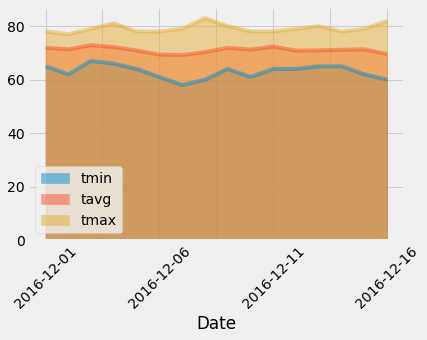

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
trips.plot.area(stacked=False)
plt.xticks(rotation=45)

In [27]:
#Temperature June
temp_june = session.query(measurement.date, measurement.tobs).\
                    filter(func.strftime("%m", measurement.date) == '06').\
                    order_by(measurement.date).all()

# Load data to a dataframe
temp_june_df = pd.DataFrame(temp_june, columns=['Date', 'Temperature'])
# Sort dataframe by date
temp_june_df = temp_june_df.sort_values(by='Date', ascending=True)
# Set date as index
temp_june_df.set_index('Date', inplace=True)
temp_june_df.describe()


,Temperature
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


In [28]:
# Temperature December
temp_dec = session.query(measurement.date, measurement.tobs).\
                    filter(func.strftime("%m", measurement.date) == '12').\
                    order_by(measurement.date).all()

# Load data to a dataframe
temp_dec_df = pd.DataFrame(temp_dec, columns=['Date', 'Temperature'])
# Sort dataframe by date
temp_dec_df = temp_dec_df.sort_values(by='Date', ascending=True)
# Set date as index
temp_dec_df.set_index('Date', inplace=True)
temp_dec_df.describe()


,Temperature
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000
